# 15. PySR 樹深度實驗

測試不同 `maxsize` 參數對 PySR 符號回歸結果的影響。

## 實驗目的
1. 比較不同 maxsize (10, 25, 40, 60) 產生的公式複雜度
2. 評估公式複雜度與預測性能 (AUC) 的權衡
3. 找出可解釋性與預測力平衡的最佳設定

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score
from imblearn.over_sampling import SMOTE

# PySR
from pysr import PySRRegressor

# 設定中文字體
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'SimHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

print("套件載入完成")

Detected Jupyter notebook. Loading juliacall extension. Set `PYSR_AUTOLOAD_EXTENSIONS=no` to disable.
套件載入完成


## 1. 載入資料

In [2]:
# 載入處理好的資料
data_path = Path('../../data/01_primary/SUA/processed/SUA_CVDs_wide_format.csv')
df = pd.read_csv(data_path)
print(f"資料形狀: {df.shape}")

資料形狀: (6056, 107)


In [3]:
# 定義特徵
feature_names = [
    'sex', 'Age',
    'FBG_T1', 'TC_T1', 'Cr_T1', 'UA_T1', 'GFR_T1', 'BMI_T1', 'SBP_T1', 'DBP_T1',
    'FBG_T2', 'TC_T2', 'Cr_T2', 'UA_T2', 'GFR_T2', 'BMI_T2', 'SBP_T2', 'DBP_T2',
    'Delta1_FBG', 'Delta1_TC', 'Delta1_Cr', 'Delta1_UA', 'Delta1_GFR', 'Delta1_BMI', 'Delta1_SBP', 'Delta1_DBP'
]

X = df[feature_names]
y_hypertension = (df['hypertension_T3'] == 2).astype(int)
y_hyperglycemia = (df['hyperglycemia_T3'] == 2).astype(int)
y_dyslipidemia = (df['dyslipidemia_T3'] == 2).astype(int)

print(f"特徵數: {len(feature_names)}")
print(f"高血壓患病率: {y_hypertension.mean():.2%}")
print(f"高血糖患病率: {y_hyperglycemia.mean():.2%}")
print(f"高血脂患病率: {y_dyslipidemia.mean():.2%}")

特徵數: 26
高血壓患病率: 16.68%
高血糖患病率: 5.53%
高血脂患病率: 5.96%


In [4]:
# 資料分割與標準化
X_train, X_test, y_train_hp, y_test_hp = train_test_split(
    X, y_hypertension, test_size=0.2, random_state=42, stratify=y_hypertension
)

# 標準化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train_hp)

print(f"訓練集: {X_train_scaled.shape[0]} -> SMOTE後: {X_train_smote.shape[0]}")
print(f"測試集: {X_test_scaled.shape[0]}")

訓練集: 4844 -> SMOTE後: 8072
測試集: 1212


## 2. PySR 不同 maxsize 實驗

In [5]:
def run_pysr_with_maxsize(X_train, y_train, X_test, y_test, feature_names, 
                          maxsize=25, niterations=100, timeout=300):
    """
    執行 PySR 實驗並返回結果
    """
    print(f"\n=== maxsize={maxsize}, niterations={niterations} ===")
    
    model = PySRRegressor(
        niterations=niterations,
        binary_operators=["+", "-", "*", "/"],
        unary_operators=["exp", "log", "abs", "neg"],
        maxsize=maxsize,
        populations=15,
        population_size=50,
        parsimony=0.0032,  # 複雜度懲罰
        timeout_in_seconds=timeout,
        temp_equation_file=True,
        tempdir="./pysr_temp",
        random_state=42,
        deterministic=True,
        procs=0,
        multithreading=False,
        progress=True,
        verbosity=0,
    )
    
    # 訓練
    model.fit(X_train, y_train, variable_names=feature_names)
    
    # 預測
    y_pred_proba = model.predict(X_test)
    y_pred_proba = np.clip(y_pred_proba, 0, 1)  # 確保在 [0, 1] 範圍內
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    # 評估
    try:
        auc = roc_auc_score(y_test, y_pred_proba)
    except:
        auc = 0.5
    
    # 取得最佳公式
    best_eq = str(model.sympy())
    
    # 取得所有公式（不同複雜度）
    equations_df = model.equations_
    
    results = {
        'maxsize': maxsize,
        'niterations': niterations,
        'AUC': auc,
        'F1': f1_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        '最佳公式': best_eq,
        '公式長度': len(best_eq),
        'equations_df': equations_df,
        'model': model
    }
    
    print(f"  AUC: {auc:.3f}")
    print(f"  Recall: {results['Recall']:.3f}")
    print(f"  公式長度: {len(best_eq)}")
    print(f"  最佳公式: {best_eq[:100]}..." if len(best_eq) > 100 else f"  最佳公式: {best_eq}")
    
    return results

In [6]:
# 測試不同 maxsize
maxsize_values = [10, 25, 40, 60]
all_results = []

print("開始 PySR 深度實驗（高血壓）...")
print("注意：每個設定可能需要 3-5 分鐘")

for maxsize in maxsize_values:
    result = run_pysr_with_maxsize(
        X_train_smote, y_train_smote,
        X_test_scaled, y_test_hp,
        feature_names,
        maxsize=maxsize,
        niterations=100,
        timeout=300
    )
    all_results.append(result)

開始 PySR 深度實驗（高血壓）...
注意：每個設定可能需要 3-5 分鐘

=== maxsize=10, niterations=100 ===
  AUC: 0.714
  Recall: 0.723
  公式長度: 29
  最佳公式: 0.22708337*SBP_T1 + 0.4387607

=== maxsize=25, niterations=100 ===
  AUC: 0.500
  Recall: 0.000
  公式長度: 17
  最佳公式: 0.499997000000000

=== maxsize=40, niterations=100 ===
  AUC: 0.711
  Recall: 0.723
  公式長度: 42
  最佳公式: Abs(0.24594943*SBP_T1 + 0.426715030136758)

=== maxsize=60, niterations=100 ===
  AUC: 0.500
  Recall: 0.000
  公式長度: 17
  最佳公式: 0.499997000000000


In [7]:
# 整理結果
summary_df = pd.DataFrame([{
    'maxsize': r['maxsize'],
    'AUC': r['AUC'],
    'F1': r['F1'],
    'Recall': r['Recall'],
    'Precision': r['Precision'],
    '公式長度': r['公式長度']
} for r in all_results])

print("\n=== 不同 maxsize 結果比較 ===")
display(summary_df)


=== 不同 maxsize 結果比較 ===


,maxsize,AUC,F1,Recall,Precision,公式長度
0,10,0.713653,0.388815,0.722772,0.265938,29
1,25,0.500000,0.000000,0.000000,0.000000,17
2,40,0.711153,0.388815,0.722772,0.265938,42
3,60,0.500000,0.000000,0.000000,0.000000,17


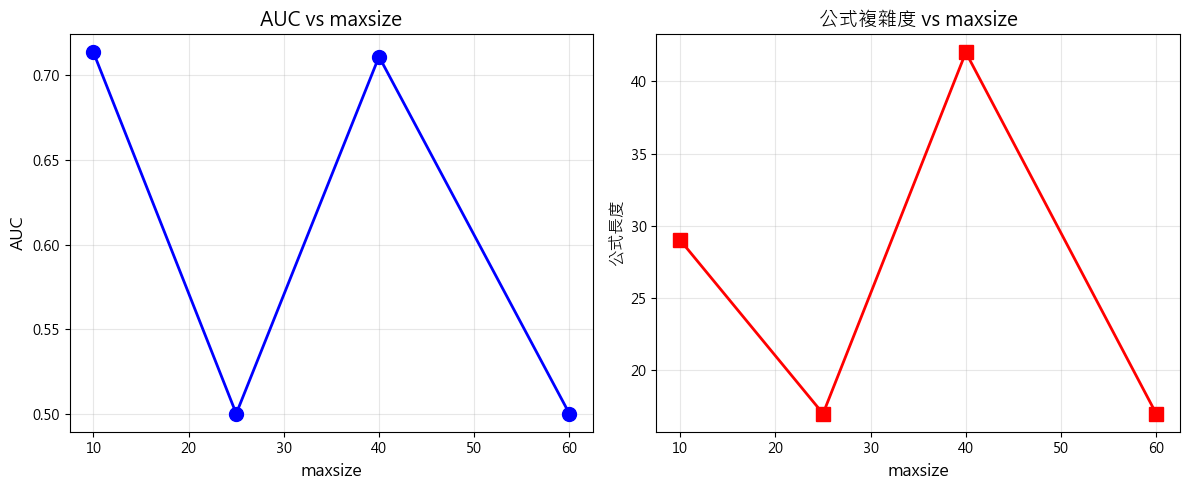

In [8]:
# 視覺化: AUC vs maxsize
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# AUC
axes[0].plot(summary_df['maxsize'], summary_df['AUC'], 'bo-', linewidth=2, markersize=10)
axes[0].set_xlabel('maxsize', fontsize=12)
axes[0].set_ylabel('AUC', fontsize=12)
axes[0].set_title('AUC vs maxsize', fontsize=14)
axes[0].grid(True, alpha=0.3)

# 公式長度
axes[1].plot(summary_df['maxsize'], summary_df['公式長度'], 'rs-', linewidth=2, markersize=10)
axes[1].set_xlabel('maxsize', fontsize=12)
axes[1].set_ylabel('公式長度', fontsize=12)
axes[1].set_title('公式複雜度 vs maxsize', fontsize=14)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../../results/figures/pysr_maxsize_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. 各 maxsize 的公式展示

In [9]:
# 顯示每個 maxsize 的最佳公式
print("=== 各 maxsize 產生的最佳公式 ===")
for r in all_results:
    print(f"\n--- maxsize={r['maxsize']} (AUC={r['AUC']:.3f}) ---")
    print(f"公式: {r['最佳公式']}")

=== 各 maxsize 產生的最佳公式 ===

--- maxsize=10 (AUC=0.714) ---
公式: 0.22708337*SBP_T1 + 0.4387607

--- maxsize=25 (AUC=0.500) ---
公式: 0.499997000000000

--- maxsize=40 (AUC=0.711) ---
公式: Abs(0.24594943*SBP_T1 + 0.426715030136758)

--- maxsize=60 (AUC=0.500) ---
公式: 0.499997000000000


In [10]:
# 顯示每個 maxsize 的 Pareto 前沿（不同複雜度的公式）
print("\n=== 各 maxsize 的 Pareto 前沿 ===")
for r in all_results:
    print(f"\n--- maxsize={r['maxsize']} ---")
    eq_df = r['equations_df']
    if eq_df is not None and len(eq_df) > 0:
        # 選擇部分欄位顯示
        display_cols = ['complexity', 'loss', 'equation']
        available_cols = [c for c in display_cols if c in eq_df.columns]
        print(eq_df[available_cols].head(10))


=== 各 maxsize 的 Pareto 前沿 ===

--- maxsize=10 ---
   complexity      loss                                           equation
0           1  0.250000                                         0.49998006
1           2  0.250000                                     abs(-0.499997)
2           4  0.223369                           exp(-1.3193742 + SBP_T1)
3           5  0.204723                  0.4387607 + (SBP_T1 * 0.22708337)
4           6  0.203794           abs(0.42682752 - (SBP_T1 * -0.24583727))
5           8  0.202946      1.136535 * exp(neg(exp(SBP_T1 * -0.6678049)))
6          10  0.202946  exp(neg(exp(SBP_T1 * -0.6678049) + 0.004468227...

--- maxsize=25 ---
   complexity      loss                                           equation
0           1  0.774430                                        -0.22417513
1           2  0.250000                                     abs(-0.499997)
2           5  0.204735                 (SBP_T1 * 0.22977473) + 0.44049883
3           6  0.203794      

## 4. 與其他模型比較

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# 訓練基準模型
print("=== 基準模型 ===")

# LR
lr = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
lr.fit(X_train_smote, y_train_smote)
lr_auc = roc_auc_score(y_test_hp, lr.predict_proba(X_test_scaled)[:, 1])
print(f"Logistic Regression AUC: {lr_auc:.3f}")

# RF
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_train_smote, y_train_smote)
rf_auc = roc_auc_score(y_test_hp, rf.predict_proba(X_test_scaled)[:, 1])
print(f"Random Forest AUC: {rf_auc:.3f}")

# XGBoost
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
xgb_model.fit(X_train_smote, y_train_smote)
xgb_auc = roc_auc_score(y_test_hp, xgb_model.predict_proba(X_test_scaled)[:, 1])
print(f"XGBoost AUC: {xgb_auc:.3f}")

=== 基準模型 ===
Logistic Regression AUC: 0.748
Random Forest AUC: 0.788
XGBoost AUC: 0.754


In [12]:
# 綜合比較
comparison_data = [
    {'模型': 'Logistic Regression', 'AUC': lr_auc, '可解釋性': '高', '公式長度': '-'},
    {'模型': 'Random Forest', 'AUC': rf_auc, '可解釋性': '低', '公式長度': '-'},
    {'模型': 'XGBoost', 'AUC': xgb_auc, '可解釋性': '低', '公式長度': '-'},
]

for r in all_results:
    comparison_data.append({
        '模型': f'PySR (maxsize={r["maxsize"]})',
        'AUC': r['AUC'],
        '可解釋性': '高',
        '公式長度': r['公式長度']
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n=== 模型比較 ===")
display(comparison_df)


=== 模型比較 ===


,模型,AUC,可解釋性,公式長度
0,Logistic Regression,0.747843,高,-
1,Random Forest,0.787984,低,-
2,XGBoost,0.754220,低,-
3,PySR (maxsize=10),0.713653,高,29
4,PySR (maxsize=25),0.500000,高,17
5,PySR (maxsize=40),0.711153,高,42
6,PySR (maxsize=60),0.500000,高,17


## 5. 結論

In [13]:
# 儲存結果
import os
os.makedirs('../../results/tables', exist_ok=True)
os.makedirs('../../results/figures', exist_ok=True)

# 儲存摘要
summary_df.to_csv('../../results/tables/pysr_maxsize_comparison.csv', index=False)

# 儲存公式
formulas_df = pd.DataFrame([{
    'maxsize': r['maxsize'],
    'AUC': r['AUC'],
    '公式': r['最佳公式']
} for r in all_results])
formulas_df.to_csv('../../results/tables/pysr_formulas.csv', index=False)

# 儲存比較表
comparison_df.to_csv('../../results/tables/pysr_model_comparison.csv', index=False)

print("結果已儲存")

結果已儲存


In [14]:
# 最終建議
print("\n=== 實驗結論 ===")
best_result = max(all_results, key=lambda x: x['AUC'])
print(f"\n最佳 AUC: maxsize={best_result['maxsize']}, AUC={best_result['AUC']:.3f}")
print(f"最佳公式: {best_result['最佳公式']}")
print(f"\n建議:")
print(f"- 如果重視可解釋性: 使用較小 maxsize (10-25)")
print(f"- 如果重視預測性能: 使用較大 maxsize (40-60)")
print(f"- PySR 提供了 AUC 與可解釋性的良好平衡")


=== 實驗結論 ===

最佳 AUC: maxsize=10, AUC=0.714
最佳公式: 0.22708337*SBP_T1 + 0.4387607

建議:
- 如果重視可解釋性: 使用較小 maxsize (10-25)
- 如果重視預測性能: 使用較大 maxsize (40-60)
- PySR 提供了 AUC 與可解釋性的良好平衡
